# Glacier image classification using convolutional networks


---

## Preliminary Steps: packages, libraries, environment configuration

Next, all the necessary libraries to be used are imported. In addition, the functions library is loaded, which was written to make this work more readable. 

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive/')
!ls '/content/drive/MyDrive/PORTAFOLIO_RRNN/functions/'
import sys # anadir directorio al path de trabajo
sys.path.append('/content/drive/MyDrive/PORTAFOLIO_RRNN/functions/')

In [ ]:
%%capture
!pip install py7zr

In [ ]:
# Imports
import py7zr
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from numpy.random import seed

import os
import sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D, MaxPooling2D, GlobalMaxPooling2D, ELU, Add, ReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
from tabulate import tabulate
import itertools

from tensorflow.keras.applications import imagenet_utils, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive, files
import json

import importlib
import functions
importlib.reload(functions)

from functions import create_environment, sampling_k_elements, create_image, show_plot, get_tabulate, get_best_model, evaluate_model, get_tabulate_test, show_plot_experiments, get_table_alone

In [ ]:
# fix seed
seed(7)
tf.random.set_seed(8)

We will work on the following route:

In [ ]:
# Creating an absolute path to the google drive directory
BASE_FOLDER = "/content/drive/MyDrive/PORTAFOLIO_RRNN"
os.chdir(BASE_FOLDER)

## Data upload from the Kaggle platform

In [ ]:
%%capture
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Select the previously downloaded personal API token (kaggle.json file).
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# create a directory for the file kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download data
start_descarga = False

if start_descarga:
  !kaggle competitions download -c statoil-iceberg-classifier-challenge

In [ ]:
# create a directory to decompress the create_environment function data from the functions file.
create_environment()

In [ ]:
# Unzip the data and leave them ready to work with
start_unzip = False

if start_unzip:
  !unzip statoil-iceberg-classifier-challenge.zip -d my_dataset

In [ ]:
# Extract test data in test folder
with py7zr.SevenZipFile(os.path.join('my_dataset', 'test.json.7z'), 'r') as archive:
  archive.extractall(path= os.path.join('my_dataset', 'test'))

In [ ]:
# Extract training data in training folder
with py7zr.SevenZipFile(os.path.join('my_dataset', 'train.json.7z'), 'r') as archive:
  archive.extractall(path= os.path.join('my_dataset', 'train'))

In [ ]:
# Load data
df_train = pd.read_json(os.path.join('my_dataset', 'train', 'data', 'processed', 'train.json'))      
df_test = pd.read_json(os.path.join('my_dataset', 'test', 'data', 'processed', 'test.json')) 

In [ ]:
# Check if the data was loaded in pandas correctly.
print(f"Datos de training {df_train.shape}")
print(f"Datos de test {df_test.shape}")

Datos de training (1604, 5)
Datos de test (8424, 4)


## Inspection of the data set

### *Training* set

In [ ]:
df_train.sample(2)

,id,band_1,band_2,inc_angle,is_iceberg
1530,b7555b43,"[-18.795044, -18.414627, -19.753613, -22.64731...","[-22.851553, -23.495295, -27.357836, -27.35788...",na,0
617,617bf094,"[-21.36175, -21.888382, -20.865387, -22.258163...","[-27.213686, -26.885931, -27.554462, -28.27876...",38.9194,0


The training dataset contains 1605 rows and 5 columns. 
- The first column corresponds to the identifier (**id**) of the image.
- The second (**band_1**) and third column (**band_2**) correspond to the images as *flattened* *array* (flattened images). Each band has 75x75 pixel values in a list, so each list contains 5625 elements. Each of these values is expressed in db. Both bands are signals characterized by radar backscatter produced by different polarizations at a particular angle of incidence. 
- The fourth column (**inc_angle**) corresponds to the angle of incidence at which the images were taken. 
- The last column (**is_iceberg**) corresponds to the label. When this value is really an iceberg then it takes a value of 1. Otherwise, if it is a ship, it takes a value of 0.

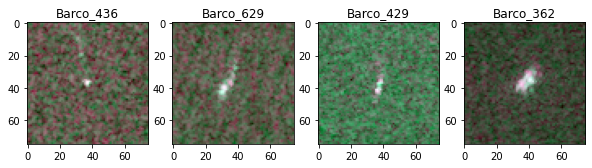

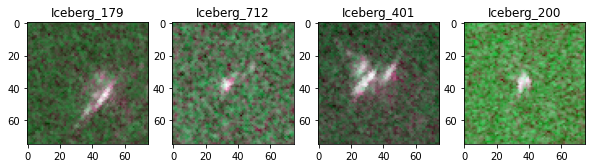

In [ ]:
ship = df_train[df_train['is_iceberg'] == 0]
iceberg = df_train[df_train['is_iceberg'] == 1]
ship_images = create_image(ship)
iceberg_images = create_image(iceberg)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,5))
j = 0
for j in range(4):      
  num = np.random.randint(0, ship_images.shape[0])  
  axes[j].imshow(ship_images[num])
  axes[j].set_title('Barco_'+str(num))
  j+=1


fig2, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,5))
j = 0
for j in range(4):      
  num = np.random.randint(0, iceberg_images.shape[0])  
  axes[j].imshow(iceberg_images[num])
  axes[j].set_title('Iceberg_'+str(num))
  j+=1

Little information is apparent to the human eye from the images. The angle of incidence measured in the image is probably important, but not much information can be extracted from them. Moreover, there is no difference between the two classes.

#### Number of images per class

In [ ]:
clases, frec = np.unique(df_train['is_iceberg'], return_counts=True)
print(f'Hay {frec[0]} imágenes correspondientes a la clase {clases[0]}')
print(f'Hay {frec[1]} imágenes correspondientes a la clase {clases[1]}')

Hay 851 imágenes correspondientes a la clase 0
Hay 753 imágenes correspondientes a la clase 1


Therefore, there is a small imbalance between the classes. There are 100 more images for the ship class.

#### Missing values of the fourth column (inc_angle)

In the description of the dataset, it is detailed that some values of the fourth column (inc_angle) do not exist. For this, we will visualize how many columns have na values in their angle of incidence.

In [ ]:
valores_na = len(df_train[df_train.inc_angle == "na"])
print(valores_na ,'filas tienen valores na en la columna del ángulo de incidencia')

133 filas tienen valores na en la columna del ángulo de incidencia


#### Balance of classes





To balance the classes, we will adjust both classes to the smallest number of images we have, that is, to 753 images.

In [ ]:
df_train = df_train.groupby('is_iceberg').apply(sampling_k_elements).reset_index(drop=True)

In [ ]:
clases, frec = np.unique(df_train['is_iceberg'], return_counts=True)
print(f'Hay {frec[0]} imágenes correspondientes a la clase {clases[0]}')
print(f'Hay {frec[1]} imágenes correspondientes a la clase {clases[1]}')

Hay 753 imágenes correspondientes a la clase 0
Hay 753 imágenes correspondientes a la clase 1


#### Subdivision of the training dataframe in x_train, y_train

In [ ]:
x_train = df_train.iloc[:, 0:4]
y_train = df_train.iloc[:, -1]

In [ ]:
# Comprobamos que la partición tenga el mismo numero de filas
print(x_train.shape)
print(y_train.shape)

(1506, 4)
(1506,)


### Test set (without labels)

In [ ]:
df_test.sample(2)

,id,band_1,band_2,inc_angle
6166,6b7c271e,"[-22.372992, -19.874268999999998, -19.450537, ...","[-24.311192, -26.494137, -30.828371, -30.33195...",39.7005
4458,5e079fbc,"[-20.515629, -23.108391, -17.278784, -14.70801...","[-25.993183, -26.821121, -24.767962, -23.69435...",31.0475


The test set has 8424 rows and the same columns as the training set, but without the label. For this reason, it will be necessary to partition the training data twice. A first external partition (train and test) and a second internal partition (train, evaluation).

#### Missing values of the fourth column (inc_angle)

In [ ]:
valores_na_test = len(df_test[df_test.inc_angle == "na"])
print(valores_na_test ,'filas tienen valores na en la columna del ángulo de incidencia')

0 filas tienen valores na en la columna del ángulo de incidencia


All test data have an angle of incidence

## Generation and conditioning of the data set

### External data partitioning

As described above, the test set downloaded from the Kaggle platform is not labeled. For this reason, we will proceed to perform an external and internal partitioning of the train data to obtain the training, evaluation and test dataset. The external partition will consider 10% for test data.

In [ ]:
# Partición externa del dataset training
x_tre, x_te, y_tre, y_te = train_test_split(x_train, y_train, test_size = 0.1, random_state=42, shuffle=True) 

In [ ]:
# Comprobación del desbalance de clases en los datos de training
clases_tr, frec_tr = np.unique(y_tre, return_counts=True)
print(f'Hay {frec_tr[0]} imágenes correspondientes a la clase {clases_tr[0]} en el conjunto de training y evaluación')
print(f'Hay {frec_tr[1]} imágenes correspondientes a la clase {clases_tr[1]} en el conjunto de training y evaluación')

Hay 681 imágenes correspondientes a la clase 0 en el conjunto de training y evaluación
Hay 674 imágenes correspondientes a la clase 1 en el conjunto de training y evaluación


In [ ]:
# Comprobación del desbalance de clases en los datos de test 
clases_te, frec_te = np.unique(y_te, return_counts=True)
print(f'Hay {frec_te[0]} imágenes correspondientes a la clase {clases_te[0]} en el conjunto de test')
print(f'Hay {frec_te[1]} imágenes correspondientes a la clase {clases_te[1]} en el conjunto de test')

Hay 72 imágenes correspondientes a la clase 0 en el conjunto de test
Hay 79 imágenes correspondientes a la clase 1 en el conjunto de test


### Internal data partitioning

Internal partitioning will be performed on the training data. A 10% will be considered for the evaluation of the model.

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_tre, y_tre, test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
# Comprobación del desbalance de clases en los datos de training
clases_train, frec_train = np.unique(y_tr, return_counts=True)
print(f'Hay {frec_train[0]} imágenes correspondientes a la clase {clases_train[0]} en el conjunto de training')
print(f'Hay {frec_train[1]} imágenes correspondientes a la clase {clases_train[1]} en el conjunto de training')

Hay 608 imágenes correspondientes a la clase 0 en el conjunto de training
Hay 611 imágenes correspondientes a la clase 1 en el conjunto de training


In [ ]:
# Comprobación del desbalance de clases en los datos de test 
clases_eval, frec_eval = np.unique(y_val, return_counts=True)
print(f'Hay {frec_eval[0]} imágenes correspondientes a la clase {clases_eval[0]} en el conjunto de evaluación')
print(f'Hay {frec_eval[1]} imágenes correspondientes a la clase {clases_eval[1]} en el conjunto de evaluación')

Hay 73 imágenes correspondientes a la clase 0 en el conjunto de evaluación
Hay 63 imágenes correspondientes a la clase 1 en el conjunto de evaluación


### Transformation of bands into RGB image

The images are defined by bands, as mentioned above. There are different ways to approach this problem. One of them would be to create a model for band 1, another for band 2, create a model with both bands and even create hybrid models that consider the images as well as other characteristics, such as the angle of incidence. In this case, we opted for a model that considers both bands as will be seen below.

To compose a third horizontal and vertical feedback band should then be as simple as band_3 = band_1 + band_2, since our data are in Decibels which are logarithmic. For this we make use of the create_image function in the functions file. Additionally, this function gives us the image **rescaled in the range between 0 and 1**, rescaling according to the depth of field of the image.

We apply the transformation and obtain the dimension of our training dataset. Which corresponds to 1604 images of 75 x 75 pixels, with 3 channels. Therefore, we have shown that we have a 4D tensor, which is what corresponds when we work with images.

In [ ]:
Xtrain = create_image(x_tre)
x_train_rgb = create_image(x_tr)
x_test_rgb = create_image(x_te)
x_val_rgb = create_image(x_val)

In [ ]:
#Expand dimensions because in CNN I have to specify the number of channels.
Xtrain = np.array(Xtrain)
x_tr = np.array(x_train_rgb)
x_te = np.array(x_test_rgb)
x_val = np.array(x_val_rgb)
y_tr = np.array(y_tr).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

In [ ]:
# Change axes
Ytrain = np.expand_dims(y_tre, 1)
y_train = np.expand_dims(y_tr, 1)
y_te = np.expand_dims(y_te, 1)
y_val = np.expand_dims(y_val, 1)

# Strategy 1: Training from scratch

## Neural network topology (CNN) and training

### Definition of architecture

Using API Functional

Below under the function **get_model** is the architecture that gave the best results. It was developed with a functional API of keras and consists of 4 convolutional blocks in the base model. It can be noticed, that the last three convolutional blocks have the same number of filters. Normally they should be increasing, but with these values, the best results were achieved.
The TOP model consists of two dense layers of 512 neurons and 256 neurons respectively.  The output dense layer consists of a single neuron activated with the sigmoid function. As this was a binary classification problem, the sigmoid activation function performed well.

In [ ]:
def get_model(input_shape, kernel_size):
  print("[INFO]: Creando artquitectura de la red...")    #sparse_categorical_crossentropy
  inputs = Input(shape=input_shape)

  # Primer set de capas
  x1 = Conv2D(32, kernel_size=kernel_size, padding="same", activation="relu")(inputs) 
  x1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x1) 
  x1 = Dropout(0.2)(x1) 

  # Segundo set de capas
  x2 = Conv2D(128, kernel_size=kernel_size, padding="same", activation="relu")(x1) 
  x2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x2) 
  x2 = Dropout(0.2)(x2) 

  # tercer set de capas
  x3 = Conv2D(128, kernel_size=kernel_size, padding="same", activation="relu")(x2) 
  x3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x3) 
  x3 = Dropout(0.2)(x3) #

  # cuarto set de capas
  x4 = Conv2D(128, kernel_size=kernel_size, padding="same", activation="relu")(x3) 
  x4 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x4) 
  x4 = Dropout(0.2)(x4)
  x4 = GlobalMaxPooling2D()(x4) 

  # TOP MODEL
  xfc = Dense(512, activation="relu")(x4)
  xfc = Dropout(0.2)(xfc) #(X)
  xfc = Dense(256, activation="relu")(xfc) 
  xfc = Dropout(0.2)(xfc) #(X)

  initializer = tf.keras.initializers.GlorotUniform(seed=42)
  predictions = Dense(1,
                      kernel_initializer=initializer,
                      activation='sigmoid')(xfc) 

  # Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs
  model = Model(inputs=inputs, outputs=predictions) 
  return model

#### Reduciendo el sobreajuste con aumento de datos

Some of the experiments carried out on the network were with data augmentation. For this purpose, the data image used is shown below.

In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.1, # fraccion del total (1) para mover la imagen
    height_shift_range=0.1, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    vertical_flip = True, # eje horizontal
    zoom_range=0.2, # rango de zoom
    validation_split = 0.1
)

### Training the net

The TrainModel function allows to train the model with different parameters to be passed in the constructor, which correspond to the parameter dictionary containing data related to the route to save the model, to make the checkpoints and to save the history, and to the train_param dictionary containing data related to the compilation of the model.

In [ ]:
class TrainModel:
  ''' Clase para el entrenamiento del modelo
  '''

  def __init__(self, parameter, train_param, verbose=2):
    print("[INFO]: Comenzando la clase base para crear modelo ...")  
    self.verbose = verbose
    self.x_train = x_train
    self.y_train = y_train
    self.x_val = x_val
    self.y_val = y_val
    self.parameter = parameter
    self.train_param = train_param

    self.callbacks = self.get_callbacks()

  def get_callbacks(self, patience=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    check_point = ModelCheckpoint(os.path.join('Models', self.parameter['path_name'], 'weights.hdf5'), monitor='val_loss', verbose=self.verbose, save_best_only=True)
    history_logger = CSVLogger(os.path.join('Models', self.parameter['path_name'], 'history.log'), separator=",", append=False)
    return [early_stopping, check_point, history_logger]

  def compile_model(self, model_input, optimizer_name):
    print("[INFO]: Compilando el modelo...")
    if optimizer_name == 'Adam':
      optimizer_model=Adam(learning_rate=self.train_param['lr'],
                                     decay=self.train_param['decay'], 
                                     beta_1=self.train_param['beta_1'], 
                                     beta_2=self.train_param['beta_2'], 
                                     epsilon=self.train_param['epsilon'])
    elif optimizer_name == 'SGD':
      optimizer_model = SGD(learning_rate=self.train_param['lr'], momentum=0.9, nesterov=True)

    model_input.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=optimizer_model, 
                      metrics=["binary_accuracy"]
                      ) 
    return model_input

  def train_model(self, model_input, x_train, y_train, x_val=None, y_val=None, data_augmentation=False):
    print("[INFO]: Entrenando la red...") 

    if data_augmentation:
      try:
        steps_per_epoch = 4*len(x_train) // self.parameter['batch_size']
        train_generator = datagen.flow(
                          x_train, 
                          y_train,
                          batch_size=self.parameter['batch_size'],
                          seed = 42,
                          subset='training') 

        validation_generator = datagen.flow(
                          x_train, 
                          y_train,
                          batch_size=self.parameter['batch_size'],
                          seed = 42,
                          subset='validation')
        
        H = model_input.fit(train_generator,
                           steps_per_epoch=steps_per_epoch, 
                           epochs=self.parameter['epochs'],
                           validation_data = validation_generator,
                           workers=2,
                           callbacks=self.callbacks,
                           verbose=self.verbose
                           )
      except KeyboardInterrupt:
          print('Interrumped')

    else:
      H = model_input.fit(x_train, y_train, 
                      batch_size=self.parameter['batch_size'], 
                      epochs=self.parameter['epochs'], 
                      validation_data=(x_val, y_val),
                      callbacks=self.callbacks
                      )
      
    return H

  def create_json(self, path_name, hyperparameters):
    with open(os.path.join('Models', path_name, 'hyperparameters.json'), 'w') as fp:
      json.dump(hyperparameters, fp)

  def save_model(self, model_input, path_name):
    print("[INFO]: Guardando el modelo...")
    model_input.save(os.path.join('Models', path_name))
    return

## Experiments

Several experiments were carried out in order to tune the hyperparameters and find the best solution. The following is a summary of the most important experiments that were carried out.

### Useful functions

In [ ]:
input_shape = x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]

In [ ]:
# Start the training training
def start_training_model(list_model, optimizer_name, prefix, data_augmentation=False):
  global input_shape
  i = 0
  for element in list_model:
    kernel_dict = {'kernel_size': element[2]}
    param = {'batch_size': element[1], 
            'epochs': 250, 
            'path_name': prefix+'_model_'+str(i)
            }
    train_param = {'lr': element[0] ,'decay' : 0, 'beta_1' : 0.9, 'beta_2': 0.999, 'epsilon' : 1e-08}
    res = {**param, **train_param, **kernel_dict}
    model = get_model(input_shape, kernel_dict['kernel_size'])
    instance = TrainModel(param, train_param)
    instance.compile_model(model, optimizer_name)
    history = instance.train_model(model, x_tr, y_tr, x_val, y_val, data_augmentation)
    instance.create_json(param['path_name'], res)
    instance.save_model(model, param['path_name'])
    i+=1
  return

In [ ]:
# Start training with data augmentation
def start_training_model_data_augmentation(list_model, optimizer_name, prefix, data_augmentation=False):
  global input_shape
  i = 0
  for element in list_model:
    kernel_dict = {'kernel_size': element[2]}
    param = {'batch_size': element[1], 
            'epochs': 250, 
            'path_name': prefix+'_model_'+str(i)
            }
    train_param = {'lr': element[0] ,'decay' : 0, 'beta_1' : 0.9, 'beta_2': 0.999, 'epsilon' : 1e-08}
    res = {**param, **train_param, **kernel_dict}
    model = get_model(input_shape, kernel_dict['kernel_size'])
    instance = TrainModel(param, train_param)
    instance.compile_model(model, optimizer_name)
    history = instance.train_model(model, Xtrain, Ytrain, None, None, data_augmentation)
    instance.create_json(param['path_name'], res)
    instance.save_model(model, param['path_name'])
    i+=1
  return

In [ ]:
# Load model
def load_total_data(experiment_list, names_list):
  model_load = {}
  i = 0
  for element in experiment_list:
    json_data = os.path.join('Models',  names_list[i], 'hyperparameters.json')
    with open(json_data) as file:
      data = json.load(file)
    kernel_dict = {'kernel_size': data['kernel_size']}
    param = {'batch_size': data['batch_size'], 'epochs':  data['epochs'], 'path_name': os.path.join('Models', data['path_name'], 'weights.hdf5')}
    train_param = {'lr': data['lr'] ,'decay' : data['decay'], 'beta_1' : data['beta_1'], 'beta_2': data['beta_2'], 'epsilon' : data['epsilon']}
    model = load_model(os.path.join('Models', names_list[i]))
    history = pd.read_csv(os.path.join('Models', names_list[i], 'history.log'), sep=',', engine='python')
    model_load[i] = {'name': 'model_'+str(i), 
                    'model': model,
                    'history': history, 
                    'train_param': train_param, 
                    'param': param, 
                    'kernel_size': kernel_dict}
    i+=1
  return model_load

### Experiment 1: Tuning of hyperparameters, using the Adam optimiser, without data augmentation.

Parameter tuning will then be performed to understand the behaviour of the model when hyperparameters are changed.

In [ ]:
sess = tf.function()  
lr_list = [0.0008, 0.001, 0.005]
bz_list = [16, 32, 64, 128]
kz_list = [(3,3), (5,5)]
a = [lr_list, bz_list, kz_list]
comb1 = list(itertools.product(*a))

In [ ]:
# Start experiment 1
%%capture
start_training_model(comb1, optimizer_name='Adam', prefix='exp1')

In [ ]:
# Load experiment 1 in memory
print(sys.getrecursionlimit())
sys.setrecursionlimit(10**6)
names = ['exp1_model_'+str(i) for i in range(0, 24)]
model_load = load_total_data(comb1, names)

1000000


### Experiment 2: Parameter tuning, using the SGD optimiser, without data augmentation.

In [ ]:
sess = tf.function() 
lr_list_2 = [0.001, 0.005, 0.01]
bz_list_2 = [16, 32, 64, 128]
kz_list_2 = [(3,3), (5,5)]
b = [lr_list_2, bz_list_2, kz_list_2]
experiment2 = list(itertools.product(*b))

In [ ]:
#%%capture
# Start experiment 2
start_training_model(experiment2, optimizer_name='SGD', prefix='exp2')

In [ ]:
print(sys.getrecursionlimit())
sys.setrecursionlimit(10**6)
# Cargo experimento 2
names = ['exp2_model_'+str(i) for i in range(0, 24)]
model_exp2 = load_total_data(experiment2, names)

1000


### Experiment 3: Parameter tuning, corresponding to experiment 1 , but with data augmentation (Adam)

In [ ]:
sess = tf.function() 
lr_list = [0.0008, 0.001, 0.005]
bz_list = [16, 32, 64, 128]
kz_list = [(3,3), (5,5)]
dat = [lr_list, bz_list, kz_list]
comb3 = list(itertools.product(*dat))

In [ ]:
# Start experiment 3
#%%capture
start_training_model_data_augmentation(comb3, optimizer_name='Adam', prefix='exp3', data_augmentation=True)

In [ ]:
# Load experiment 3
names = ['exp3_model_'+str(i) for i in range(0, 24)]
model_exp3 = load_total_data(comb3, names)

### Experiment 4: Hyperparameter tuning, corresponding to Experiment 2, but with data augmentation (SGD)

In [ ]:
sess = tf.function() 
lr_list_4 = [0.001, 0.005, 0.01]
bz_list_4 = [16, 32, 64, 128]
kz_list_4 = [(3,3), (5,5)]
c = [lr_list_4, bz_list_4, kz_list_4]
experiment4 = list(itertools.product(*c))

In [ ]:
# Start experiment 4
start_training_model_data_augmentation(experiment4, optimizer_name='SGD', prefix='exp4', data_augmentation=True)

In [ ]:
# Load experiment 4
names = ['exp4_model_'+str(i) for i in range(0, 24)]
model_exp4 = load_total_data(experiment4, names)

## Monitoring of the training process for decision making


We call the show_plot function in our functions folder to plot the results of our 4 experiments.

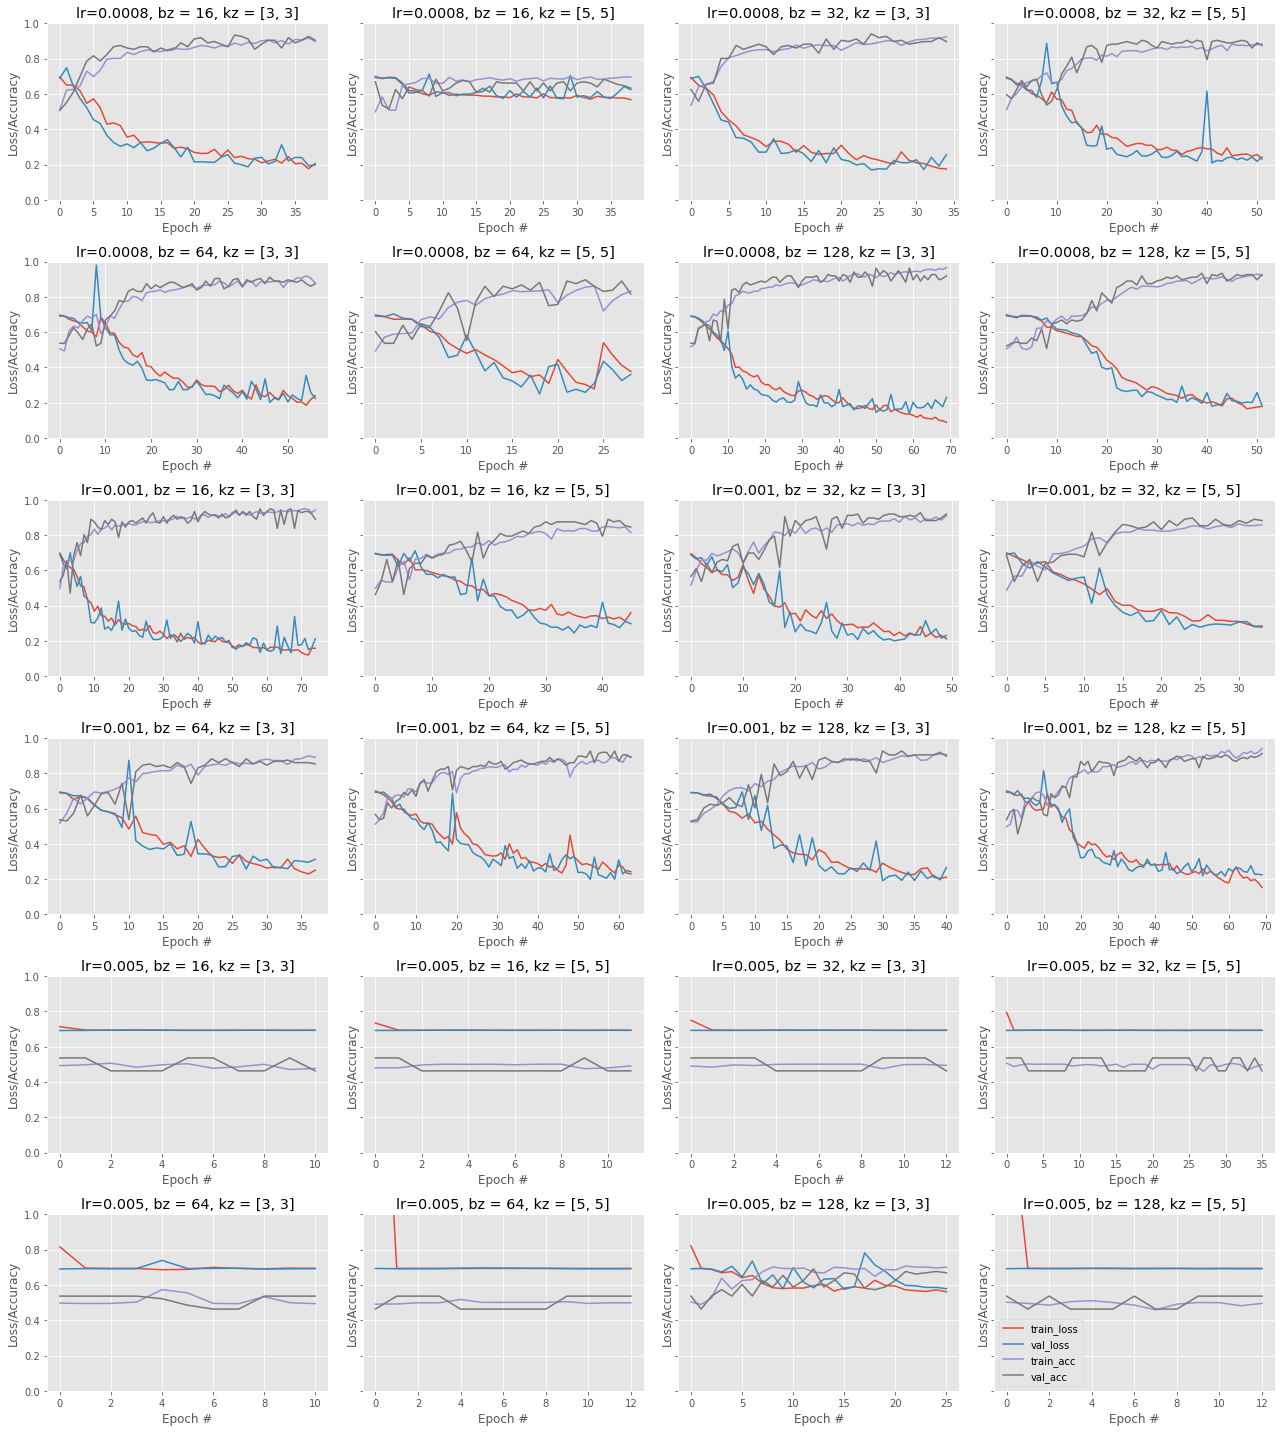

In [ ]:
show_plot(model_load, 4)

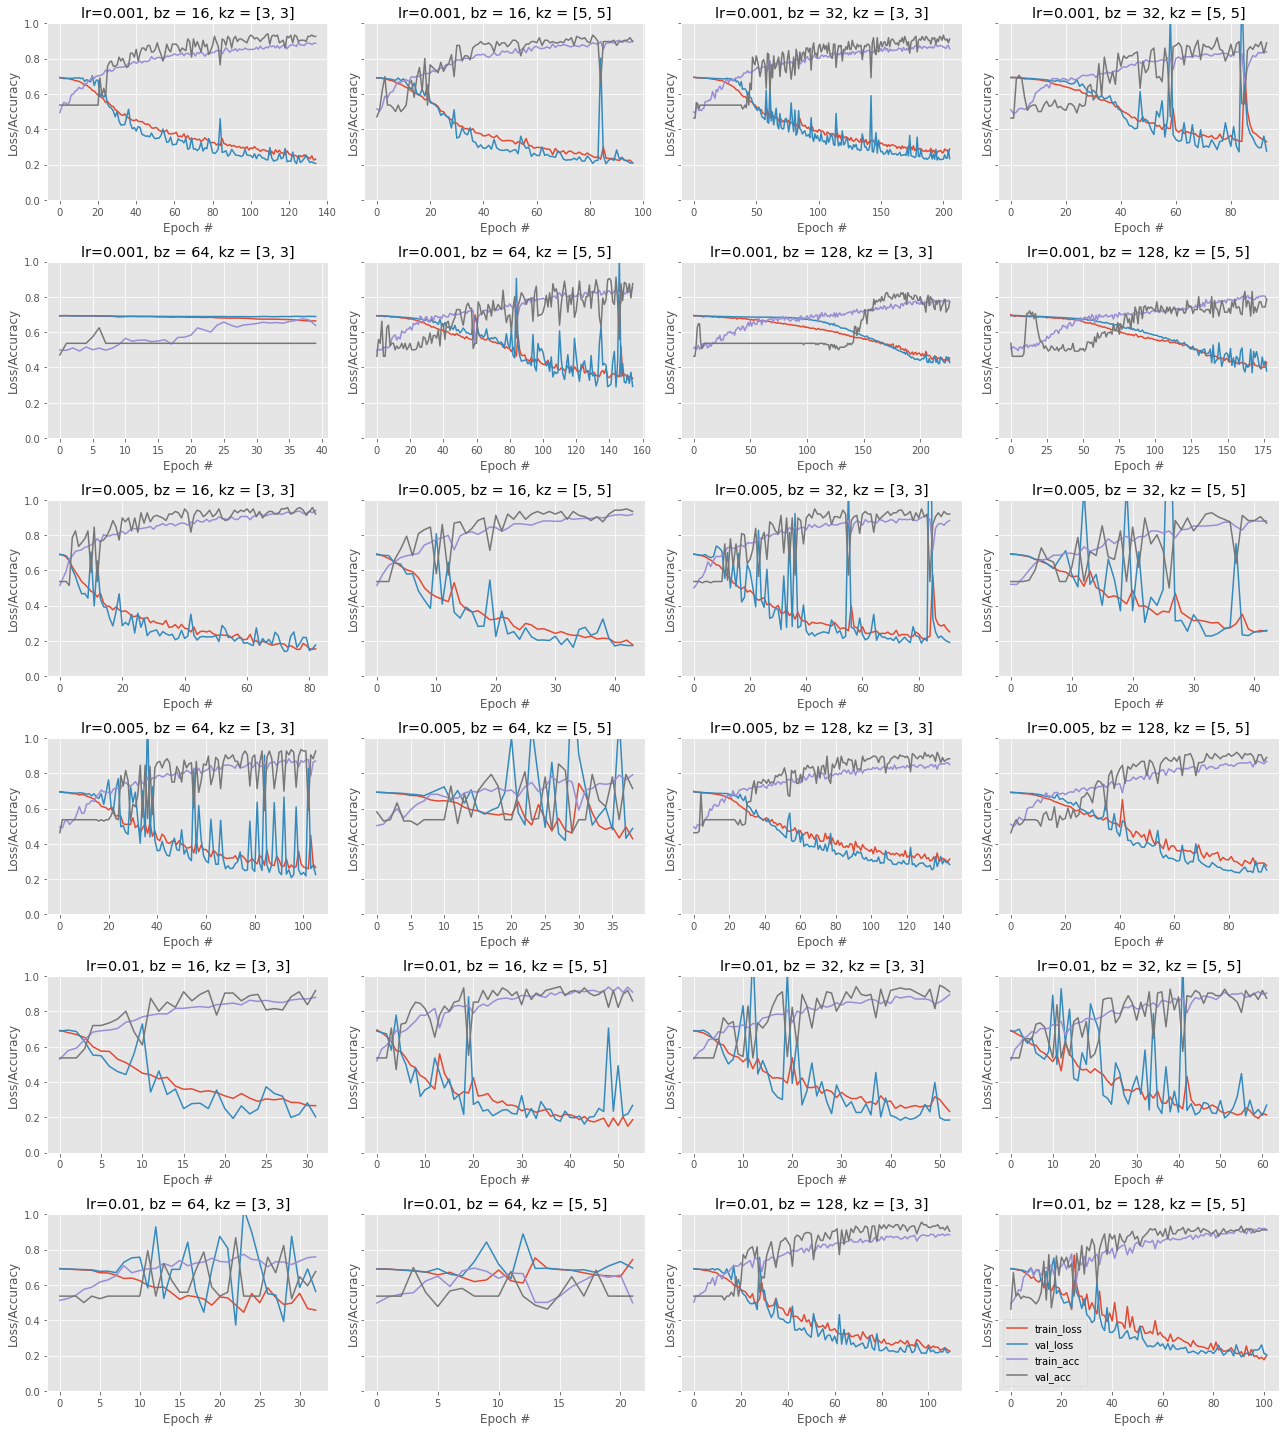

In [ ]:
show_plot(model_exp2, 4)

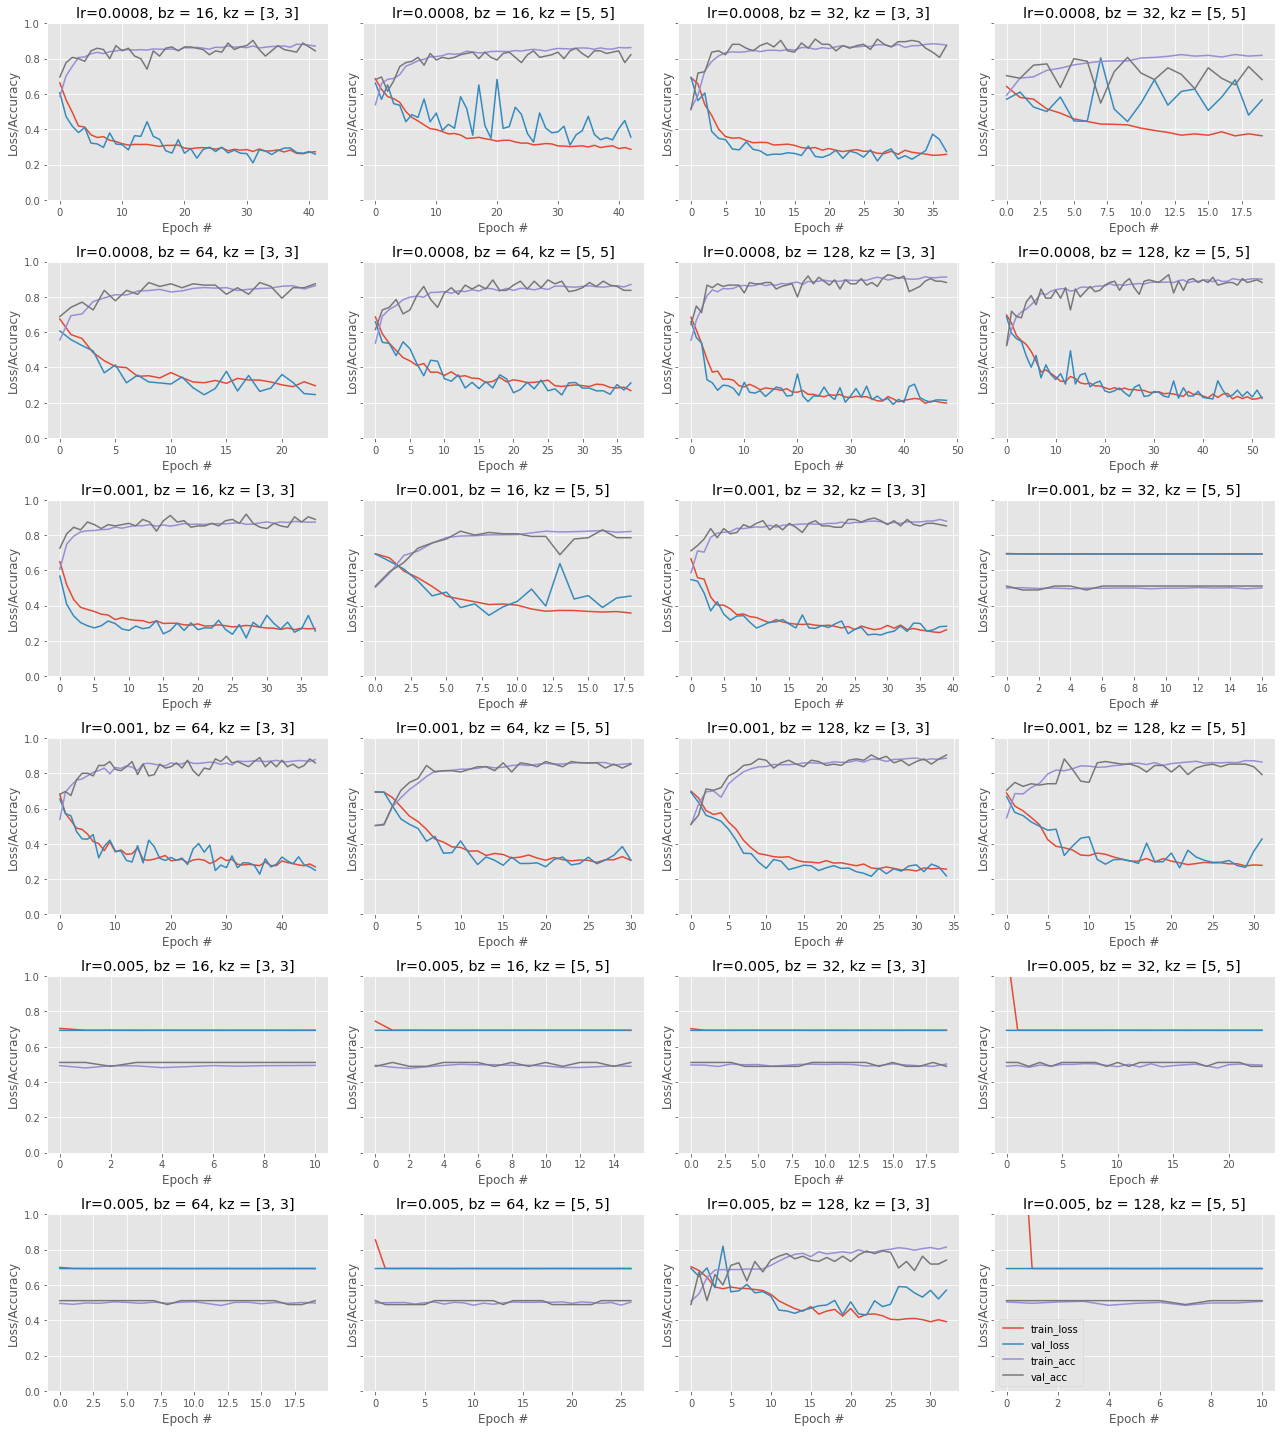

In [ ]:
show_plot(model_exp3, 4)

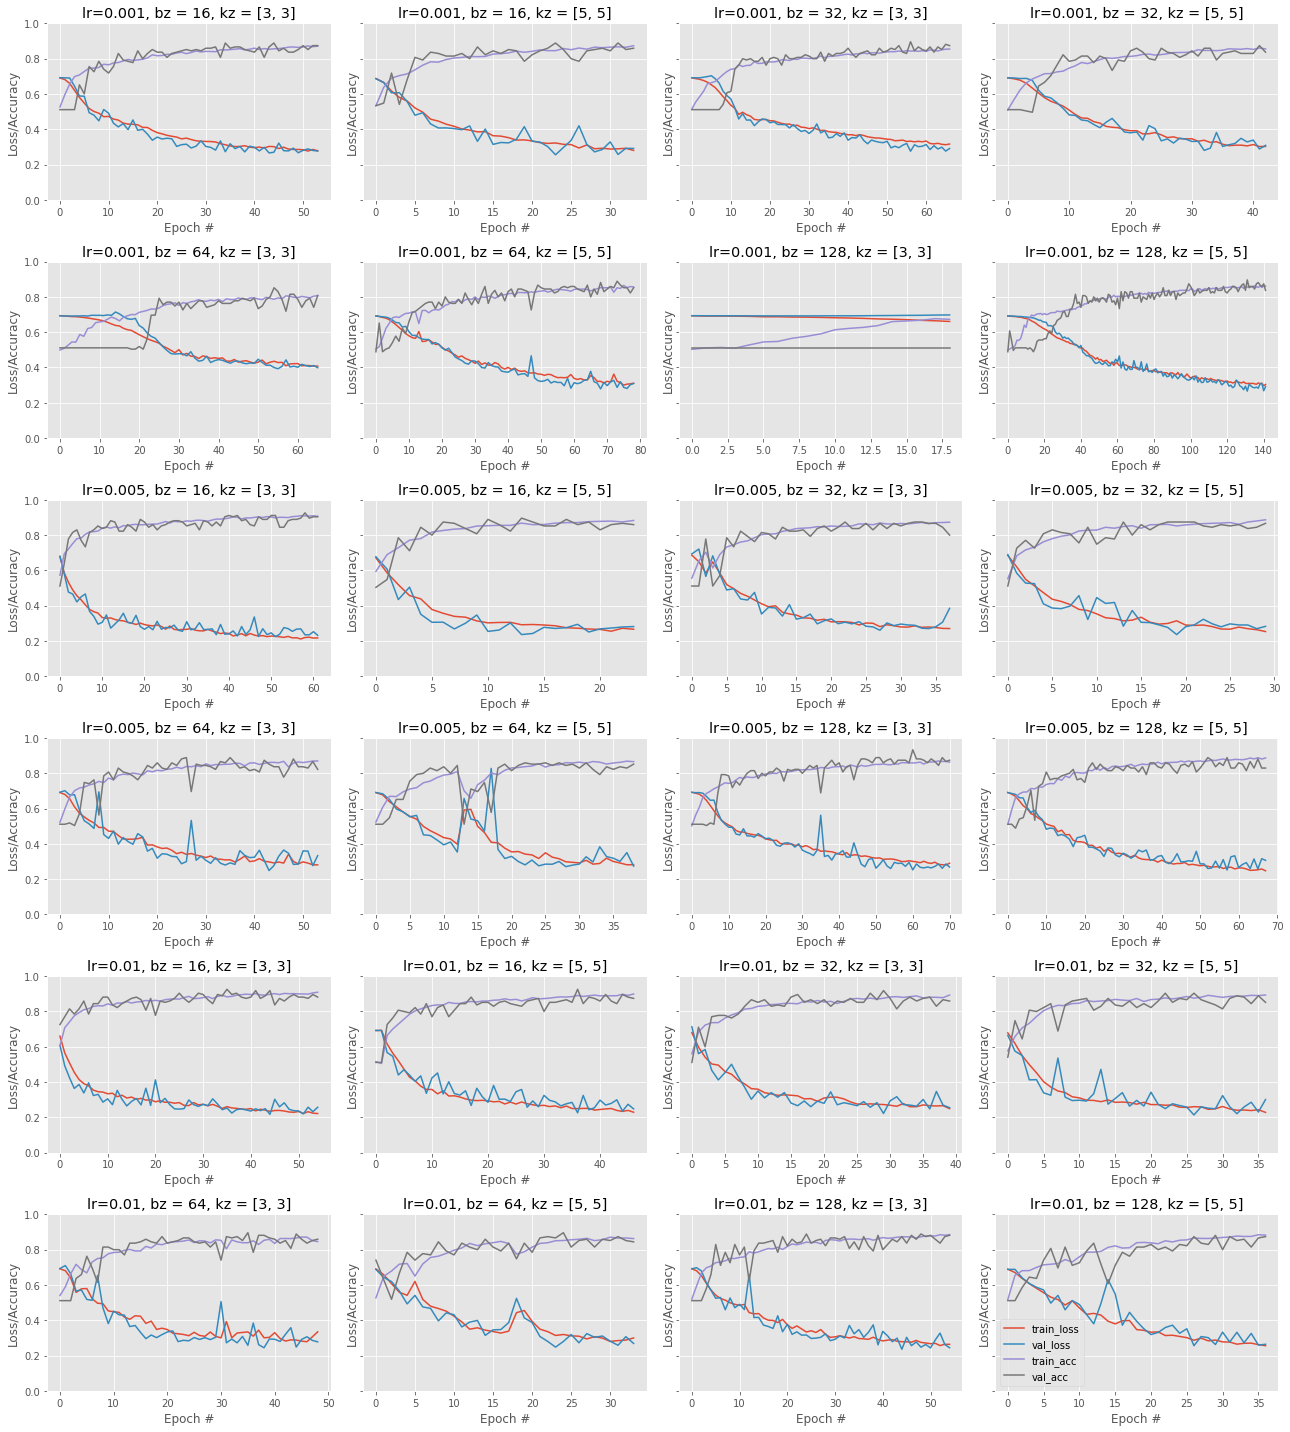

In [ ]:
show_plot(model_exp4, 4)

## Internal evaluation of the model

The results have been displayed graphically, as well as in tabular form. The function get_best_model mos delivers the 3 best models of each experiment. Additionally, the information can be complemented with the graphs obtained in the previous section.

In [ ]:
# Best results experiment 1
best_model = get_best_model(model_load)

+---------+--------+--------+-----+--------+---------+--------+----------+---------+
|  Model  | epochs |   lr   | bs  |   ks   | tr_loss | tr_acc | val_loss | val_acc |
+---------+--------+--------+-----+--------+---------+--------+----------+---------+
| model_0 |   38   | 0.0008 | 16  | [3, 3] |  0.206  | 0.897  |  0.198   |  0.904  |
| model_7 |   51   | 0.0008 | 128 | [5, 5] |  0.179  | 0.921  |  0.183   |  0.926  |
| model_8 |   74   | 0.001  | 16  | [3, 3] |  0.158  | 0.942  |  0.212   |  0.89   |
+---------+--------+--------+-----+--------+---------+--------+----------+---------+


In [ ]:
# Best results experiment 2 
best_model_2 = get_best_model(model_exp2)

+----------+--------+-------+----+--------+---------+--------+----------+---------+
|  Model   | epochs |  lr   | bs |   ks   | tr_loss | tr_acc | val_loss | val_acc |
+----------+--------+-------+----+--------+---------+--------+----------+---------+
| model_8  |   82   | 0.005 | 16 | [3, 3] |  0.155  | 0.939  |  0.177   |  0.919  |
| model_9  |   43   | 0.005 | 16 | [5, 5] |  0.179  | 0.917  |  0.174   |  0.934  |
| model_18 |   52   | 0.01  | 32 | [3, 3] |  0.233  | 0.895  |  0.185   |  0.912  |
+----------+--------+-------+----+--------+---------+--------+----------+---------+


In [ ]:
# Best results experiment 3
best_model_3 = get_best_model(model_exp3)

+----------+--------+--------+-----+--------+---------+--------+----------+---------+
|  Model   | epochs |   lr   | bs  |   ks   | tr_loss | tr_acc | val_loss | val_acc |
+----------+--------+--------+-----+--------+---------+--------+----------+---------+
| model_6  |   48   | 0.0008 | 128 | [3, 3] |  0.198  | 0.912  |  0.213   |  0.881  |
| model_7  |   52   | 0.0008 | 128 | [5, 5] |  0.232  |  0.9   |  0.225   |  0.881  |
| model_14 |   34   | 0.001  | 128 | [3, 3] |  0.256  | 0.886  |  0.218   |  0.904  |
+----------+--------+--------+-----+--------+---------+--------+----------+---------+


In [ ]:
# Best results experiment 4
best_model_4 = get_best_model(model_exp4)

+----------+--------+-------+-----+--------+---------+--------+----------+---------+
|  Model   | epochs |  lr   | bs  |   ks   | tr_loss | tr_acc | val_loss | val_acc |
+----------+--------+-------+-----+--------+---------+--------+----------+---------+
| model_8  |   61   | 0.005 | 16  | [3, 3] |  0.217  | 0.907  |  0.232   |  0.904  |
| model_17 |   46   | 0.01  | 16  | [5, 5] |  0.229  | 0.899  |  0.248   |  0.874  |
| model_22 |   54   | 0.01  | 128 | [3, 3] |  0.263  | 0.886  |  0.244   |  0.881  |
+----------+--------+-------+-----+--------+---------+--------+----------+---------+


Based on these four experiments, we conducted further tests to verify the models and compare them in terms of internal evaluation metrics. In the end, the best performing model was the following:

In [ ]:
# Experiment 3: Adam data augmentation
lr_3 = 0.0008
bs_3 = 128   #16
ks_3 = (3,3) 

In [ ]:
lr_list_final3 = [lr_3]
bz_list_final3 = [bs_3]
kz_list_final3 = [ks_3]
h = [lr_list_final3, bz_list_final3, kz_list_final3]
experiment_final3 = list(itertools.product(*h))
print(experiment_final3)

[(0.0008, 128, (3, 3))]


Start training process

In [ ]:
sess = tf.function() 
start_training_model(experiment_final3, optimizer_name='Adam', prefix='exp_adam_dataug', data_augmentation=True)

[INFO]: Creando artquitectura de la red...
[INFO]: Comenzando la clase base para crear modelo ...
[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/250

Epoch 1: val_loss improved from inf to 0.69432, saving model to Models/exp_adam_dataug_model_0/weights.hdf5
38/38 - 18s - loss: 0.6939 - binary_accuracy: 0.5026 - val_loss: 0.6943 - val_binary_accuracy: 0.4793 - 18s/epoch - 479ms/step
Epoch 2/250

Epoch 2: val_loss improved from 0.69432 to 0.62628, saving model to Models/exp_adam_dataug_model_0/weights.hdf5
38/38 - 5s - loss: 0.6511 - binary_accuracy: 0.6392 - val_loss: 0.6263 - val_binary_accuracy: 0.6694 - 5s/epoch - 137ms/step
Epoch 3/250

Epoch 3: val_loss did not improve from 0.62628
38/38 - 5s - loss: 0.5792 - binary_accuracy: 0.6964 - val_loss: 0.6477 - val_binary_accuracy: 0.6446 - 5s/epoch - 136ms/step
Epoch 4/250

Epoch 4: val_loss improved from 0.62628 to 0.47226, saving model to Models/exp_adam_dataug_model_0/weights.hdf5
38/38 - 6s - loss: 0.5142 - binar

In [ ]:
# Cargo experimento final con Adam data augmentation
print(sys.getrecursionlimit())
sys.setrecursionlimit(10**6)
names = ['exp_adam_dataug_model_'+str(i) for i in range(0, 1)]
model_exp_final3 = load_total_data(experiment_final3, names)

1000000


<Figure size 432x288 with 0 Axes>

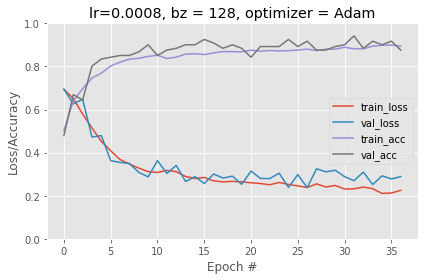

In [ ]:
# experiment 3
plt.clf()
plt.style.use("ggplot")
fig = plt.figure()
# Muestro gráfica de accuracy y losses
number_epochs=len(model_exp_final3[0]['history'].epoch)
plt.plot(np.arange(0, number_epochs), model_exp_final3[0]['history']['loss'], label="train_loss")
plt.plot(np.arange(0, number_epochs), model_exp_final3[0]['history']['val_loss'], label="val_loss")
plt.plot(np.arange(0, number_epochs), model_exp_final3[0]['history']['binary_accuracy'], label="train_acc")
plt.plot(np.arange(0, number_epochs), model_exp_final3[0]['history']['val_binary_accuracy'], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
_lr = lr_3
_bz = bs_3
_kz = ks_3
_title = 'lr='+str(_lr)+', bz = '+str(_bz)+', optimizer = Adam'
plt.title(_title)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In conclusion, the best performing model is experiment 3 with data augmentation. The parameters of the model that we will use in the next stage for the prediction stage are as follows:

In [ ]:
best_model_final = get_best_model(model_exp_final3)

+---------+--------+--------+-----+--------+---------+--------+----------+---------+
|  Model  | epochs |   lr   | bs  |   ks   | tr_loss | tr_acc | val_loss | val_acc |
+---------+--------+--------+-----+--------+---------+--------+----------+---------+
| model_0 |   36   | 0.0008 | 128 | [3, 3] |  0.225  | 0.895  |  0.289   |  0.876  |
+---------+--------+--------+-----+--------+---------+--------+----------+---------+


## Evaluation of the predictive model and approach of the following experimental test

We now proceed to the evaluation of our model. 

In [ ]:
def load_model(name):
  reconstructed_model = load_model(name)
  return reconstructed_model

In [ ]:
def evaluate_model(model_name, x_test, y_test, batch_size):
  score = model_name.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
  return score

In [ ]:
def get_tabulate_test(model_, x_te, y_te):
  headers = ['Modelo', 'epochs', 'lr', 'bs', 'ks', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
  my_data = []
  name = model_['name']
  loss, acc = evaluate_model(model_['model'], x_te, y_te, model_['param']['batch_size'])
  batch_size = model_['param']['batch_size']
  learning_rate = model_['train_param']['lr']
  epochs = model_['history'].epoch.iloc[-1]
  kernel_size = str(model_['kernel_size']['kernel_size'])
  my_data.append([name, epochs, learning_rate, batch_size, kernel_size, round(loss, 2), round(acc, 2)])
  print(tabulate(my_data, headers=headers, tablefmt="pretty", floatfmt=",.2f"))
  return

In [ ]:
get_tabulate_test(best_model_final, x_te, y_te)

+---------+--------+--------+-----+--------+------------+-----------+
| Modelo  | epochs |   lr   | bs  |   ks   | train_loss | train_acc |
+---------+--------+--------+-----+--------+------------+-----------+
| model_0 |   36   | 0.0008 | 128 | [3, 3] |    0.23    |   0.89    |
+---------+--------+--------+-----+--------+------------+-----------+


In [ ]:
def return_evaluation_model(model, batch_size, x_test_data):
  from sklearn.metrics import classification_report
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  p_pred = model.predict(x_test_data, batch_size=batch_size)
  p_pred = p_pred.flatten()
  y_pred = np.where(p_pred >= 0.5, 1, 0)
  print(classification_report(y_te, y_pred))
  print(confusion_matrix(y_te, y_pred))

In [ ]:
return_evaluation_model(model_exp_final3[0]['model'], 128, x_te)

[INFO]: Evaluando red neuronal...
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        72
           1       0.89      0.95      0.92        79

    accuracy                           0.91       151
   macro avg       0.92      0.91      0.91       151
weighted avg       0.92      0.91      0.91       151

[[63  9]
 [ 4 75]]


---
### Conclusion:
We can conclude that the model has achieved an acceptable accuracy. If we look at the confusion matrix, we can state that the model is wrong in 4 samples of the iceberg class and in 9 samples of the ship class. The methodology used of balancing the samples of both classes and then applying a data augmentation has given good results.

| Activation | Loss | accuracy |
| :- | -: | :-: |
| Sigmoid | BinaryCrossentropy() | 0.91

In future experiments, it would be interesting to work with additional features to the model, such as the difference (HH - HV) and the ratio (HH/HV). Furthermore, it would be interesting to take advantage of experience in the field to create better models, for example to consider the angle of incidence, the radar beam that is perpendicular to the surface, and the intensity of the backscatter (reflectivity), which decreases with increasing angle of incidence. These features were not considered in the model presented in this paper and could be considered in a future hybrid model.

# Strategy 2: Preetrained net

## Transfer Learning: VGG16

### Data preprocessing according to imagenet

The pre-trained network with VGG16 establishes a pre-processing of the data using the **tf.keras.applications.vgg16.preprocess_input** function. For this, the images must be unscaled.

In [ ]:
# Load data
df_train = pd.read_json(os.path.join('my_dataset', 'train', 'data', 'processed', 'train.json'))      
df_test = pd.read_json(os.path.join('my_dataset', 'test', 'data', 'processed', 'test.json')) 
df_train = df_train.groupby('is_iceberg').apply(sampling_k_elements).reset_index(drop=True)
x_train = df_train.iloc[:, 0:4]
y_train = df_train.iloc[:, -1]

In [ ]:
# External partition of the training dataset
x_tre, x_te, y_tre, y_te = train_test_split(x_train, y_train, test_size = 0.1, random_state=42, shuffle=True)
x_tr, x_val, y_tr, y_val = train_test_split(x_tre, y_tre, test_size = 0.1, random_state=42, shuffle=True)

In [ ]:
Xtrain = create_image(x_tr)*255
Xtest = create_image(x_te)*255
Xval = create_image(x_val)*255

In [ ]:
#Expand dimensions because in CNN I have to specify the number of channels.
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Xval = np.array(Xval)
Ytrain = np.array(y_tr).astype(np.float32)
Yval = np.array(y_val).astype(np.float32)
Ytest = np.array(y_te).astype(np.float32)

In [ ]:
Ytrain = np.expand_dims(Ytrain,1)
Ytest = np.expand_dims(Ytest,1)
Yval = np.expand_dims(Yval,1)

In [ ]:
# Normalisation of data as in imagenetvgg16
Xtrain = tf.keras.applications.vgg16.preprocess_input(Xtrain)
Xtest = tf.keras.applications.vgg16.preprocess_input(Xtest)
Xval = tf.keras.applications.vgg16.preprocess_input(Xval)

### Load **VGG16** model:

In [ ]:
sess = tf.function() 

In [ ]:
base_model = VGG16(weights='imagenet',
                 include_top=False, 
                 input_shape=(75,75,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [ ]:
input_shape = Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]

In [ ]:
# TOP MODEL
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False) 

x = GlobalMaxPooling2D()(x)

#xfc = Flatten()(x)
xfc = Dense(512, activation='relu')(x)
xfc = Dropout(0.2)(xfc) #(X)
xfc = Dense(256, activation="relu")(xfc) 
xfc = Dropout(0.2)(xfc) #(X)

initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid  

outputs = Dense(1,
                kernel_initializer=initializer,
                activation=activation)(x) 
model = Model(inputs, outputs)

In [ ]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=Adam(learning_rate=0.0001,
                                     decay=0.2, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-08), #lr del orden de 10-3 probar con 0.0005 y .001
                      metrics=["binary_accuracy"]
                      )

In [ ]:
def get_callbacks(patience=10):
  early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
  check_point = ModelCheckpoint(os.path.join('Models', 'vgg16_2.hdf5'), monitor='val_loss', verbose=1, save_best_only=True)
  history_logger = CSVLogger(os.path.join('Models', 'vgg16_2.log'), separator=",", append=False)
  return [early_stopping, check_point, history_logger]

### Training the net

In [ ]:
start_data_augmentation = False # no se utilizará data augmentation

In [ ]:
if start_data_augmentation:
  try:
    steps_per_epoch = 4*len(Xtrain) // 128
    train_generator = datagen.flow(
                          Xtrain, 
                          Ytrain,
                          batch_size=128,
                          seed = 42,
                          subset='training') 

    validation_generator = datagen.flow(
                          Xtrain, 
                          Ytrain,
                          batch_size=128,
                          seed = 42,
                          subset='validation')
        
    H = model.fit(train_generator,
                steps_per_epoch=steps_per_epoch, 
                epochs=250,
                validation_data = validation_generator,
                workers=2,
                callbacks=get_callbacks(),
                verbose=2
                )
  except:
    pass
else:
  H = model.fit(Xtrain, Ytrain, 
                    batch_size=128, 
                    epochs=250, 
                    validation_data=(Xval, Yval),
                    callbacks=get_callbacks()
                    )

Epoch 1/250
10/10 [==============================] - ETA: 0s - loss: 2.8274 - binary_accuracy: 0.5226
Epoch 1: val_loss improved from inf to 0.58229, saving model to Models/vgg16_2.hdf5
10/10 [==============================] - 25s 959ms/step - loss: 2.8274 - binary_accuracy: 0.5226 - val_loss: 0.5823 - val_binary_accuracy: 0.7279
Epoch 2/250
10/10 [==============================] - ETA: 0s - loss: 0.5273 - binary_accuracy: 0.7629
Epoch 2: val_loss improved from 0.58229 to 0.50447, saving model to Models/vgg16_2.hdf5
10/10 [==============================] - 3s 324ms/step - loss: 0.5273 - binary_accuracy: 0.7629 - val_loss: 0.5045 - val_binary_accuracy: 0.7647
Epoch 3/250
10/10 [==============================] - ETA: 0s - loss: 0.4595 - binary_accuracy: 0.8089
Epoch 3: val_loss improved from 0.50447 to 0.47128, saving model to Models/vgg16_2.hdf5
10/10 [==============================] - 3s 281ms/step - loss: 0.4595 - binary_accuracy: 0.8089 - val_loss: 0.4713 - val_binary_accuracy: 0.764

### Internal evaluation of the model

We see that the model converges quickly, unlike the network trained from scratch. The number of epochs required was higher due to the number of trainable parameters of VGG16, but it behaved stably, reaching an accuracy in training of 93% and in the internal evaluation phase of 84%. 

<Figure size 432x288 with 0 Axes>

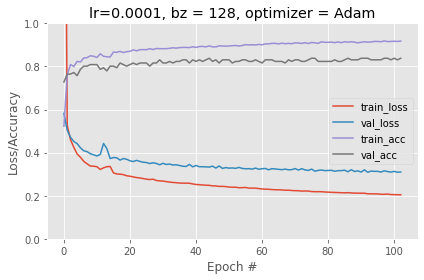

In [ ]:
# VGG16
plt.clf()
plt.style.use("ggplot")
fig = plt.figure()
# Muestro gráfica de accuracy y losses
number_epochs=len(H.epoch)
plt.plot(np.arange(0, number_epochs), H.history['loss'], label="train_loss")
plt.plot(np.arange(0, number_epochs), H.history['val_loss'], label="val_loss")
plt.plot(np.arange(0, number_epochs), H.history['binary_accuracy'], label="train_acc")
plt.plot(np.arange(0, number_epochs), H.history['val_binary_accuracy'], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
_lr = 0.0001
_bz = 128
_kz = ''
_title = 'lr='+str(_lr)+', bz = '+str(_bz)+', optimizer = Adam'
plt.title(_title)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
get_table_alone('VGG16', H, 0.0001, 128)

+--------+--------+-----+---------+--------+----------+---------+
| Modelo |   lr   | bs  | tr_loss | tr_acc | val_loss | val_acc |
+--------+--------+-----+---------+--------+----------+---------+
| VGG16  | 0.0001 | 128 |  0.205  | 0.918  |   0.31   |  0.838  |
+--------+--------+-----+---------+--------+----------+---------+


### Evaluation of the predictive model and approach of the following experimental test

By testing the model in the test phase, we see that the model delivers an accuracy of 88%, very close to the 91% achieved in the model trained from scratch. A better accuracy using fine tuning could not be verified.

In [ ]:
model.evaluate(Xtest, Ytest)
return_evaluation_model(model, 128, Xtest)

5/5 [==============================] - 1s 137ms/step - loss: 0.1984 - binary_accuracy: 0.9404
[INFO]: Evaluando red neuronal...
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        72
           1       0.94      0.95      0.94        79

    accuracy                           0.94       151
   macro avg       0.94      0.94      0.94       151
weighted avg       0.94      0.94      0.94       151

[[67  5]
 [ 4 75]]


We can affirm, that training with a pre-trained network like VGG16 gives good results, erring in 5 samples for the ship class, and in 4 samples for the iceberg class. 
As mentioned above, the results could be further improved by considering a hybrid model, where other features such as tilt angle are taken into account.

## Aprendizaje por transferencia: ResNet50

Using the pre-trained ResNet50 network, we use the function tf.keras.applications.resnet_v2.preprocess_input() for data preprocessing.

In [ ]:
# Load data
df_train = pd.read_json(os.path.join('my_dataset', 'train', 'data', 'processed', 'train.json'))      
df_test = pd.read_json(os.path.join('my_dataset', 'test', 'data', 'processed', 'test.json')) 
df_train = df_train.groupby('is_iceberg').apply(sampling_k_elements).reset_index(drop=True)
x_train = df_train.iloc[:, 0:4]
y_train = df_train.iloc[:, -1]

In [ ]:
# External partitioning of the training dataset
x_tre, x_te, y_tre, y_te = train_test_split(x_train, y_train, test_size = 0.1, random_state=42, shuffle=True)
x_tr, x_val, y_tr, y_val = train_test_split(x_tre, y_tre, test_size = 0.1, random_state=42, shuffle=True)
print(x_te.shape)

(151, 4)


In [ ]:
Xtrain = create_image(x_tr)*255
Xtest = create_image(x_te)*255
Xval = create_image(x_val)*255

In [ ]:
#Expand dimensions because in CNN I have to specify the number of channels.
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Xval = np.array(Xval)
Ytrain = np.array(y_tr).astype(np.float32)
Yval = np.array(y_val).astype(np.float32)
Ytest = np.array(y_te).astype(np.float32)

In [ ]:
Ytrain = np.expand_dims(Ytrain,1)
Ytest = np.expand_dims(Ytest,1)
Yval = np.expand_dims(Yval,1)

In [ ]:
# Data normalisation as in imagenet
Xtrain = tf.keras.applications.resnet_v2.preprocess_input(Xtrain)
Xtest = tf.keras.applications.resnet_v2.preprocess_input(Xtest)
Xval = tf.keras.applications.resnet_v2.preprocess_input(Xval)

In [ ]:
K.clear_session()
base_model_2 = tf.keras.applications.ResNet50(weights='imagenet',
                 include_top=False, 
                 input_shape=(75,75,3))

In [ ]:
print("Number of layers in the base model: ", len(base_model_2.layers))

Number of layers in the base model:  175


In [ ]:
# TOP MODEL
inputs = Input(shape=input_shape)
x = base_model_2(inputs, training=False)   #evita que pesos se modifuen

# Freeze all layers except the 50 last layers
#for layer in base_model_2.layers[:-5]: 
#    layer.trainable = True

x = GlobalMaxPooling2D()(x)

xfc = Dense(512, activation='relu')(x)
xfc = Dropout(0.2)(xfc) #(X)
xfc = Dense(256, activation="relu")(xfc) 
xfc = Dropout(0.2)(xfc) #(X)

initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid

outputs = Dense(1,
                kernel_initializer=initializer,
                activation=activation)(x) 

model_test_2 = Model(inputs, outputs)

In [ ]:
# compile the model
model_test_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=Adam(learning_rate=0.00001,
                                     decay=0.1, 
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-08), #lr del orden de 10-3 probar con 0.0005 y .001
                      metrics=["binary_accuracy"]
                      )

In [ ]:
def get_callbacks(patience=10):
  early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
  check_point = ModelCheckpoint(os.path.join('Models', 'resnet.hdf5'), monitor='val_loss', verbose=2, save_best_only=True)
  history_logger = CSVLogger(os.path.join('Models', 'resnet.log'), separator=",", append=False)
  return [early_stopping, check_point, history_logger]

In [ ]:
resnet_history = model_test_2.fit(Xtrain, Ytrain, 
                    batch_size=128, 
                    epochs=50, 
                    validation_data=(Xval, Yval),
                    callbacks=get_callbacks(),
                    verbose=2
                    )

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.61814, saving model to Models/resnet.hdf5
10/10 - 13s - loss: 0.7228 - binary_accuracy: 0.5349 - val_loss: 0.6181 - val_binary_accuracy: 0.7647 - 13s/epoch - 1s/step
Epoch 2/50

Epoch 2: val_loss improved from 0.61814 to 0.54500, saving model to Models/resnet.hdf5
10/10 - 4s - loss: 0.5978 - binary_accuracy: 0.7564 - val_loss: 0.5450 - val_binary_accuracy: 0.7721 - 4s/epoch - 357ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.54500 to 0.51540, saving model to Models/resnet.hdf5
10/10 - 4s - loss: 0.5404 - binary_accuracy: 0.7752 - val_loss: 0.5154 - val_binary_accuracy: 0.7794 - 4s/epoch - 351ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.51540 to 0.47386, saving model to Models/resnet.hdf5
10/10 - 4s - loss: 0.5059 - binary_accuracy: 0.7916 - val_loss: 0.4739 - val_binary_accuracy: 0.8235 - 4s/epoch - 354ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.47386 to 0.45529, saving model to Models/resnet.hdf5
10/10 - 4s

### Internal evaluation of the model

<Figure size 432x288 with 0 Axes>

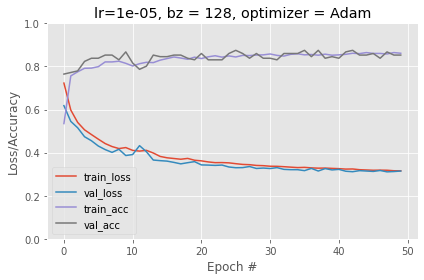

In [ ]:
# resnet
plt.clf()
plt.style.use("ggplot")
fig = plt.figure()
# Muestro gráfica de accuracy y losses
number_epochs=len(resnet_history.epoch)
plt.plot(np.arange(0, number_epochs), resnet_history.history['loss'], label="train_loss")
plt.plot(np.arange(0, number_epochs), resnet_history.history['val_loss'], label="val_loss")
plt.plot(np.arange(0, number_epochs), resnet_history.history['binary_accuracy'], label="train_acc")
plt.plot(np.arange(0, number_epochs), resnet_history.history['val_binary_accuracy'], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
_lr = 0.00001
_bz = 128
_kz = ''
_title = 'lr='+str(_lr)+', bz = '+str(_bz)+', optimizer = Adam'
plt.title(_title)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
get_table_alone('ResNet50', resnet_history, 0.00001, 128)

+----------+-------+-----+---------+--------+----------+---------+
|  Modelo  |  lr   | bs  | tr_loss | tr_acc | val_loss | val_acc |
+----------+-------+-----+---------+--------+----------+---------+
| ResNet50 | 1e-05 | 128 |  0.316  | 0.861  |  0.315   |  0.853  |
+----------+-------+-----+---------+--------+----------+---------+


### Test Phase: Prediction 

In [ ]:
model_test_2.evaluate(Xtest, Ytest)
return_evaluation_model(model_test_2, 128, Xtest)

5/5 [==============================] - 0s 35ms/step - loss: 0.3072 - binary_accuracy: 0.8742
[INFO]: Evaluando red neuronal...
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        72
           1       0.88      0.87      0.88        79

    accuracy                           0.87       151
   macro avg       0.87      0.87      0.87       151
weighted avg       0.87      0.87      0.87       151

[[63  9]
 [10 69]]


Using the RestNet50 pre-entangled network, good results were achieved by freezing the weights of the 175 layers. By fine-tuning, an accuracy of 79% was achieved. By leaving the weights frozen in their entirety, an accuracy of 87% was achieved.
The pre-entered grid is wrong on 9 and 10 samples in the ship and iceberg classes respectively. This accuracy is below that of the net trained from scratch (91%) and the pre-trained VGG16 net (94%).


---
## Comparison of the two pre-training networks

The net that delivered the best accuracy was that of VGG16. It achieved an accuracy of 94%.


| Name | epochs | accuracy | recall | f1-score |
| :- | -: | :-: | :-: | :-: |
| VGG16 | 103 | 0.94 | 0.94 | 0.94
| ResNet50 | 50 | 0.87 | 0.87 | 0.87

The VGG16 network needed more epochs to reach convergence, unlike the ResNet50 network, which was relatively fast, reaching stability in epoch 20.

With the fine-tuning technique it was not possible to improve the results obtained.

---
## Comparación entrenamiento desde cero y red pre-entrenada VGG16

| Nombre | epochs | accuracy | recall | f1-score |
| :- | -: | :-: | :-: | :-: |
| from scratch | 35 | 0.92 | 0.91 | 0.92
| VGG16 | 103 | 0.94 | 0.94 | 0.94

La red entrenada desde cero, convergió más rápido, pero alcanzó una precisión levemente por debajo de los resultados obtenidos con una red-preentrenada VGG16. Sin embargo, ésta necesitó bastantes épocas para converger.

## Ejemplo de generación de documento PDF a partir del Colab Notebook (fichero ".ipynb")

In [ ]:
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --to pdf '07MIAR_Proyecto_Programacion.ipynb'